[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/blhuillier/Olympiades/blob/main/Data/run_MCMC.ipynb
)

# Analyse finale SNIa + BAO
Dans ce notebook, nous allons analyser les données SNIa de Pantheon+ et BAO de DESI DR2. 

Pour chaque combinaison de données (SNIa, BAO, SNIa+BAO), nous allons : 
1. Calculer le "meilleur modèle"  
2. Lancer un MCMC pour explorer l'espace des paramètres  
3. Tracer les "Probabilités posterieures" $P(Paramètres | Données)

## Rappels théoriques: 

### Pour les Supernovae: 

$$\mu = m_B - M_B = 5 \log_{10}\left(\frac{d_L(z)}{1\,\mathrm{Mpc}} +25\right),$$
où $m_B$ est la ''magnitude apparente'' (observée), $M_B$ est la ''magnitude absolue'' (supposée la même pour toutes les SNIa). 
La distance $d_L(z)$ dépend elle-même des paramètres cosmologiques $(\Omega_m, \Omega_k)$. 


## Pour les BAO: 

DM is the comoving distance $$d_M(z)$$  
DH is the ``Hubble distance'' $$d_H = \frac c {H(z)}$$
DV is the spherically-averaged distance: $$D_V(z) = (zD_M(z)^2d_H(z))^{1/3}$$

$r_d$ est l'horizon sonore à l'époque du découplage. Sa valeur **exacte** est inconnue, on **marginalise** par rapport à ce paramètre. En toute rigueur, il faudrait la calculer pour chaque choix de paramètres cosmologiques. 

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
import matplotlib.colors as mcolors
# import emcee, install it if it is not already installed


# warning: need astropy >= 7.1.0
from astropy import constants as c, units as u
from astropy.cosmology import LambdaCDM
from astropy.constants import c as clight
try:
  import emcee
except:
  !pip install emcee
  import emcee
# !pip install "chainconsumer>=1.2.2"
try:
  from chainconsumer import Chain, ChainConfig, ChainConsumer, PlotConfig, Truth, make_sample
except:
  !pip install "chainconsumer>=1.2.2"
  from chainconsumer import Chain, ChainConfig, ChainConsumer, PlotConfig, Truth, make_sample
import chainconsumer
print (chainconsumer.__version__)


1.2.2


In [65]:
do_SN = True
do_BAO = True
do_MCMC = False
do_all = True


# print(mcolors.CSS4_COLORS["crimson"])  # Output: #DC143C
col_all = mcolors.CSS4_COLORS["firebrick"]

col_bao = 'indigo'
col_sn = mcolors.CSS4_COLORS["teal"]


In [66]:
# Sound Horizon at drag epoch -- the physical size of the BAO
rd = 147.1 * u.Mpc
clight = c.c.to(u.km/u.s) # speed of light in km/s

In [67]:
# Define a list of colors:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## 📥 Chargement des données DESI


In [68]:
df = pd.read_csv("https://raw.githubusercontent.com/blhuillier/Olympiades/refs/heads/main/Data/DESI_DR2.csv")

In [69]:
df

,Tracer,z_eff,DV/rd,err_DV/rd,DM/DH,err_DM/DH,"rV,M/H",DM/rd,err_DM/rd,DH/rd,err_DH/rd,"rM,H"
0,BGS,0.295,7.942,0.075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LRG1,0.510,12.720,0.099,0.622,0.017,0.050,13.588,0.167,21.863,0.425,-0.459
2,LRG2,0.706,16.050,0.110,0.892,0.021,-0.018,17.351,0.177,19.455,0.330,-0.404
3,LRG3+ELG1,0.934,19.721,0.091,1.223,0.019,0.056,21.576,0.152,17.641,0.193,-0.416
4,ELG2,1.321,24.252,0.174,1.948,0.045,0.202,27.601,0.318,14.176,0.221,-0.434
5,QSO,1.484,26.055,0.398,2.386,0.136,0.044,30.512,0.760,12.817,0.516,-0.500
6,Lya,2.330,31.267,0.256,4.518,0.097,0.574,38.988,0.531,8.632,0.101,-0.431
7,LRG3,0.922,19.656,0.105,1.232,0.021,0.106,21.648,0.178,17.577,0.213,-0.406
8,ELG1,0.955,20.008,0.183,1.220,0.033,0.420,21.707,0.335,17.803,0.297,-0.462


# SNIa

In [70]:


class PantheonPlus:
    def __init__(self):
        # Load data
        url_data = (
            "https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/"
            "refs/heads/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES.dat"
        )
        url_cov = (
            "https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/"
            "refs/heads/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES_STAT%2BSYS.cov"
        )

        df = pd.read_csv(url_data, delimiter=r'\s+')
        cov = np.loadtxt(url_cov)
        n = int(cov[0])
        cov = cov[1:].reshape((n, n))

        # Select zHD > 0.01
        mask = df['zHD'] > 0.01
        df = df.loc[mask]
        cov = cov[mask.values][:, mask.values]

        # Keep only z and m_b_corr
        self.z = df['zHD'].values
        self.mB = df['m_b_corr'].values
        self.icov = np.linalg.inv(cov)

    def chi2(self, mB_th):
        """
        Compute chi2 = (mB - mB_th)^T @ C^{-1} @ (mB - mB_th)
        """
        delta = self.mB - mB_th
        return delta @ self.icov @ delta


pantheon = PantheonPlus()

# Class BAO

In [71]:


class DESI_DR2:
    def __init__(self):
        self.df = pd.read_csv("https://raw.githubusercontent.com/blhuillier/Olympiades/refs/heads/main/Data/DESI_DR2.csv")

        # Boolean mask
        is_aniso = np.isfinite(df['DM/rd'].values)
        self.is_anisotropic = is_aniso
        self.nanisotropic = np.sum(is_aniso)
        self.nisotropic = np.sum(~is_aniso)

        # Isotropic bins (for dV only)
        df_iso = df[~is_aniso]
        self.zdV = df_iso['z_eff'].values
        self.dV_rd = df_iso['DV/rd'].values
        self.err_dV_rd = df_iso['err_DV/rd'].values

        # Anisotropic bins (for dM and dH)
        df_ani = df[is_aniso]
        self.zani = df_ani['z_eff'].values
        self.dM_rd = df_ani['DM/rd'].values
        self.err_dM_rd = df_ani['err_DM/rd'].values
        self.dH_rd = df_ani['DH/rd'].values
        self.err_dH_rd = df_ani['err_DH/rd'].values
        self.rho = df_ani['rM,H'].values

        # Precompute inverse covariances for anisotropic bins
        self.inv_cov = np.zeros((self.nanisotropic, 2, 2))
        for i in range(self.nanisotropic):
            sigM = self.err_dM_rd[i]
            sigH = self.err_dH_rd[i]
            r = self.rho[i]
            det = (sigM * sigH)**2 * (1 - r**2)
            self.inv_cov[i] = (1 / det) * np.array([
                [sigH**2, -r * sigM * sigH],
                [-r * sigM * sigH, sigM**2]
            ])

    def chi2_anisotropic(self, dM_th, dH_th):
        chi2 = 0.0

        # Anisotropic contribution
        for i in range(self.nanisotropic):
            dy = np.array([
                self.dM_rd[i] - dM_th[i],
                self.dH_rd[i] - dH_th[i]
            ])
            chi2 += dy.T @ self.inv_cov[i] @ dy
        return chi2

    def chi2_isotropic(self,dV_th):
      chi2 = 0.0
      # Isotropic contribution
      for i in range(self.nisotropic):
          dy = self.dV_rd[i] - dV_th[i]
          chi2 += (dy / self.err_dV_rd[i])**2

      return chi2

bao = DESI_DR2()


In [72]:
from functools import singledispatch
def get_chi2(theta,bao=None,snia=None):
  '''
  theta = Om0,Ok0,rd,MB
  '''
  chi2 = 0.
  Om0, Ode0 = theta[:2]
  thiscosmo = LambdaCDM(H0=70, Om0=Om0, Ode0=Ode0)

  if bao is not None:
    rd = theta[2] 
    ziso = bao.zdV
    dVrdth = (ziso * thiscosmo.comoving_transverse_distance(ziso)**2 * clight / (thiscosmo.H(ziso))).value**(1./3.) / rd
    
    chi2iso = bao.chi2_isotropic(dVrdth)
    chi2 += chi2iso
    zani = bao.zani
    dMrdth = (thiscosmo.comoving_transverse_distance(zani) / rd).value
    dHrdth = (clight / (thiscosmo.H(zani) * rd)).value
    chi2aniso = bao.chi2_anisotropic(dMrdth,dHrdth)
    chi2 += chi2aniso
  if snia is not None:
    MB = theta[-1]
    mBth = thiscosmo.distmod(snia.z).value + MB
    chi2 += snia.chi2(mBth)
  return chi2


def lnpi(theta,bounds,bao,snia):
  res = 0.
  Om0, Ode0 = theta[:2]
  if not (bounds['Om0'][0]<Om0<bounds['Om0'][1]):
    return -np.inf
  if not (bounds['Ode0'][0]<Ode0<bounds['Ode0'][1]):
    return -np.inf
  if bao is not None:
    rd = theta[2]
    if not (bounds['rd'][0]<rd<bounds['rd'][1]):
      return -np.inf
  if snia is not None:
    MB = theta[-1]
    if not (bounds['MB'][0]<MB<bounds['MB'][1]):
      return -np.inf
  return res

def lnlog(theta,bao,snia):
  return -0.5*get_chi2(theta,bao,snia)

def lnP (theta,bounds,bao,snia):
  logpi = lnpi(theta,bounds,bao,snia)
  if np.isfinite(logpi):
    return logpi + lnlog(theta,bao,snia)
  else:
    return -np.inf



# SNIa seulement

In [73]:
# find best fit

if do_SN:
  bounds = ((.1,1),(0,1),(-25,-15))
  res_sn = differential_evolution(
      get_chi2,
      bounds=bounds,
      args=(None,pantheon)
  )


  print (res_sn)

             message: Optimization terminated successfully.
             success: True
                 fun: 1403.2910891102372
                   x: [ 2.980e-01  6.194e-01 -1.935e+01]
                 nit: 16
                nfev: 809
          population: [[ 2.791e-01  5.977e-01 -1.935e+01]
                       [ 3.548e-01  8.393e-01 -1.938e+01]
                       ...
                       [ 3.039e-01  5.262e-01 -1.933e+01]
                       [ 3.762e-01  7.429e-01 -1.936e+01]]
 population_energies: [ 1.403e+03  1.421e+03 ...  1.409e+03  1.406e+03]
                 jac: [ 4.661e-03  6.571e-03  3.479e-03]


In [74]:
if do_SN:
    if do_MCMC:
        ndim = len(res_sn.x)
        # initialize
        nwalkers = 12
        niter = 5000
        # p0 = res_sn.x[:,np.newaxis] * np.random.normal(1,0.1,(ndim,nwalkers))
        p0 = res_sn.x[np.newaxis,:] * np.random.normal(1,0.1,(nwalkers,ndim))

        dic_bounds = {
            'Om0': (.1,1),
            'Ode0': (0,1),
            'rd': (100,200),
            'MB': (-25,-15)
        }
        sampler_snia = emcee.EnsembleSampler(nwalkers=nwalkers,ndim=ndim , log_prob_fn=lnP, args=(dic_bounds,None,pantheon), )
        sampler_snia.run_mcmc(p0, niter, progress=True);




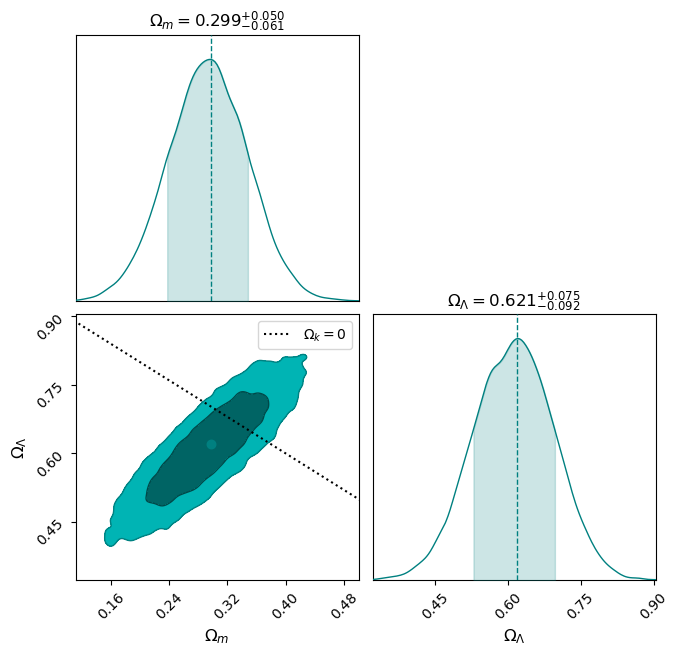

In [75]:
if do_SN:

    # Define parameter names (match order in theta)
    params_snia = [r"$\Omega_m$", r"$\Omega_\Lambda$", r"$M_B$"] #  r"$r_d$",

    chain_snia = Chain.from_emcee(sampler_snia, params_snia[:2], "SNIa", discard=200, thin=2, color=col_sn)
    c = ChainConsumer().add_chain(chain_snia)
    # Only show selected parameters (e.g., hide r_d)
    truth_sn = Truth(
        location = {param: val for param,val in zip(params_snia,res_sn.x)},
        color=col_sn, 
        marker='.'
    )
    c.add_truth(truth_sn)
    # fig=c.plotter.plot()


# Set desired limits for specific parameters
c.set_plot_config(
    PlotConfig(
        # shade=True,
        # legend=True,
        # figsize=(6, 6),
        parameters={
            r"$\Omega_\Lambda$": {"range": (0.4, 0.9)},
            r"$\Omega_m$": {"range": (0,0.5)},
        }
    )
)

  # After creating the plot:
fig = c.plotter.plot()
ax = fig.get_axes()[2]
ax.plot([0, 1], [1, 0], ls=':', color='k', label=r'$\Omega_k=0$',zorder=10)
ax.legend()


# BAO Seulement


In [76]:
# find best fit
bounds = ((.1,1),(0,1),(100,200))
res_bao = differential_evolution(
    get_chi2,
    bounds=bounds,
    args=(bao,None)
)


print (res_bao)

             message: Optimization terminated successfully.
             success: True
                 fun: 14.64709637053609
                   x: [ 2.956e-01  7.013e-01  1.449e+02]
                 nit: 27
                nfev: 1332
          population: [[ 2.946e-01  6.994e-01  1.449e+02]
                       [ 2.935e-01  7.065e-01  1.453e+02]
                       ...
                       [ 2.942e-01  7.051e-01  1.453e+02]
                       [ 2.984e-01  7.037e-01  1.448e+02]]
 population_energies: [ 1.465e+01  1.479e+01 ...  1.473e+01  1.472e+01]
                 jac: [-7.184e-04  5.073e-04 -1.776e-07]


In [77]:
if do_BAO:
    if do_MCMC:
        ndim = len(res_bao.x)
        # initialize
        nwalkers = 12
        niter = 5000
        # p0 = res_sn.x[:,np.newaxis] * np.random.normal(1,0.1,(ndim,nwalkers))
        p0 = res_bao.x[np.newaxis,:] * np.random.normal(1,0.1,(nwalkers,ndim))

        dic_bounds = {
            'Om0': (.1,1),
            'Ode0': (0,1),
            'rd': (100,200),
            'MB': (-25,-15)
        }
        sampler_bao = emcee.EnsembleSampler(nwalkers=nwalkers,ndim=ndim , log_prob_fn=lnP, args=(dic_bounds,bao,None), )
        sampler_bao.run_mcmc(p0, niter, progress=True);




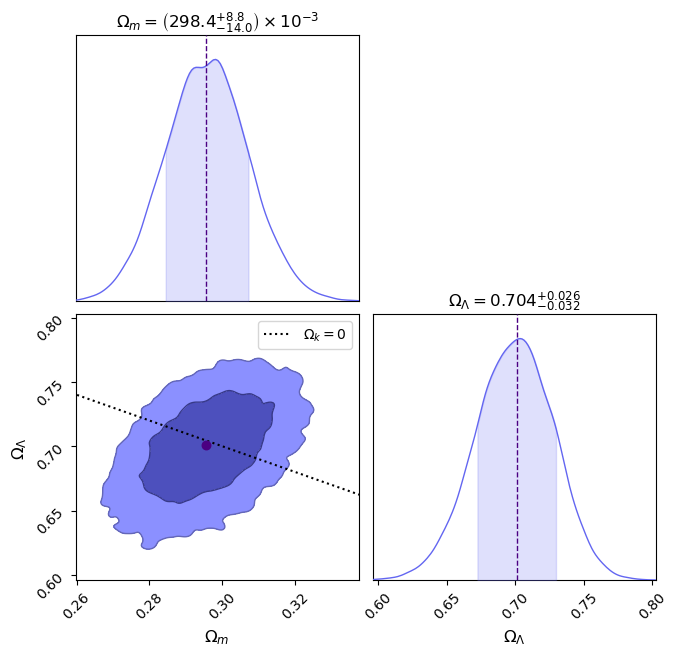

In [78]:
if do_BAO:

    # Define parameter names (match order in theta)
    params_bao = [r"$\Omega_m$", r"$\Omega_\Lambda$", r"$r_d$"] #  r"$r_d$",

    chain_bao = Chain.from_emcee(sampler_bao, params_bao[:2], "BAO", discard=200, thin=2, color=col_bao)
    c = ChainConsumer().add_chain(chain_bao)

    # Only show selected parameters (e.g., hide r_d)
    truth_bao = Truth(
        location = {param: val for param,val in zip(params_bao,res_bao.x)},
        color=col_bao, 
        marker='.',
        # markersize=.4
    )
    c.add_truth(truth_bao)


# Set desired limits for specific parameters
c.set_plot_config(
    PlotConfig(
        # shade=True,
        # legend=True,
        # figsize=(6, 6),
        parameters={
            r"$\Omega_\Lambda$": {"range": (0.4, 0.9)},
            r"$\Omega_m$": {"range": (0,0.5)},
        }
    )
)
   
  # After creating the plot:
fig = c.plotter.plot()
ax = fig.get_axes()[2]
ax.plot([0, 1], [1, 0], ls=':', color='k', label=r'$\Omega_k=0$',zorder=10)
ax.legend()

# SNIa + BAO

In [79]:
if do_all: 
    # find best fit
    bounds = ((.1,1),(0,1),(100,200),(-25,-15))
    res_all = differential_evolution(
        get_chi2,
        bounds=bounds,
        args=(bao,pantheon)
    )


    print (res_all)


             message: Optimization terminated successfully.
             success: True
                 fun: 1420.8541769379813
                   x: [ 2.963e-01  6.793e-01  1.440e+02 -1.936e+01]
                 nit: 22
                nfev: 1505
          population: [[ 2.949e-01  6.897e-01  1.444e+02 -1.936e+01]
                       [ 3.024e-01  6.918e-01  1.439e+02 -1.935e+01]
                       ...
                       [ 2.950e-01  6.915e-01  1.443e+02 -1.936e+01]
                       [ 2.695e-01  6.521e-01  1.443e+02 -1.936e+01]]
 population_energies: [ 1.421e+03  1.431e+03 ...  1.423e+03  1.429e+03]
                 jac: [ 1.550e-01 -3.229e-02  1.114e-03  5.041e-02]


In [80]:
if do_all:
    if do_MCMC:
        ndim = len(res_all.x)
        # initialize
        nwalkers = 12
        niter = 5000
        # p0 = res_sn.x[:,np.newaxis] * np.random.normal(1,0.1,(ndim,nwalkers))
        p0 = res_all.x[np.newaxis,:] * np.random.normal(1,0.1,(nwalkers,ndim))

        sampler_all = emcee.EnsembleSampler(nwalkers=nwalkers,ndim=ndim , log_prob_fn=lnP, args=(dic_bounds,bao,pantheon), )
        sampler_all.run_mcmc(p0, niter, progress=True);




(0.0, 0.5)

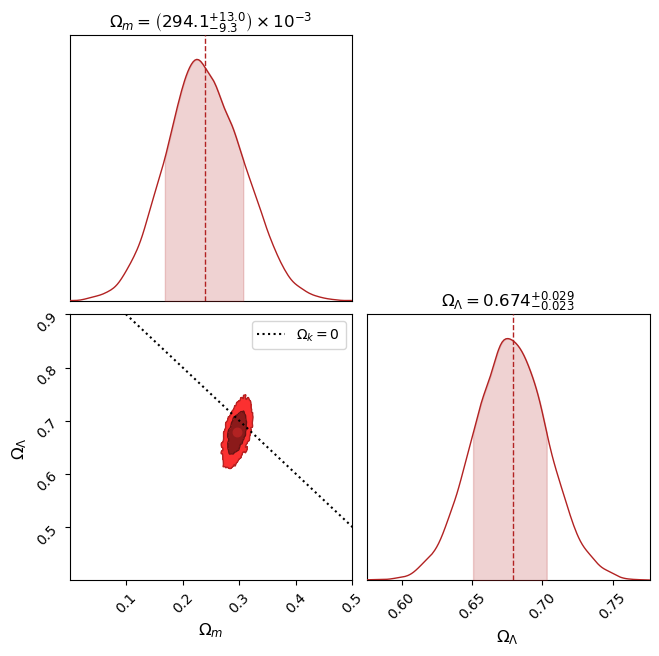

In [81]:
if do_all:

    # Define parameter names (match order in theta)
    params_all = [r"$\Omega_m$", r"$\Omega_\Lambda$", r"$r_d$",r"$M_B$"] 

    chain_all = Chain.from_emcee(sampler_all, params_bao[:2], "BAO+SNIa", discard=200, thin=2,color=col_all)
    c = ChainConsumer().add_chain(chain_all)
    truth_all = Truth(
        location = {param: val for param,val in zip(params_all,res_all.x)},
        color=col_all, 
        marker='.'
    )
    c.add_truth(truth_all)

# Set desired limits for specific parameters
c.set_plot_config(
    PlotConfig(
        # shade=True,
        # legend=True,
        # figsize=(6, 6),
        parameters={
            r"$\Omega_\Lambda$": {"range": (0.4, 0.9)},
            r"$\Omega_m$": {"range": (0,0.5)},
        }
    )
)
  # After creating the plot:
fig = c.plotter.plot()
ax = fig.get_axes()[2]
ax.plot([0, 1], [1, 0], ls=':', color='k', label=r'$\Omega_k=0$',zorder=10)
ax.legend()
ax.set_ylim(0.4,.9)
ax.set_xlim(0,.5)

# Combine chains

On peut maintenant combiner les differentes chaines : 

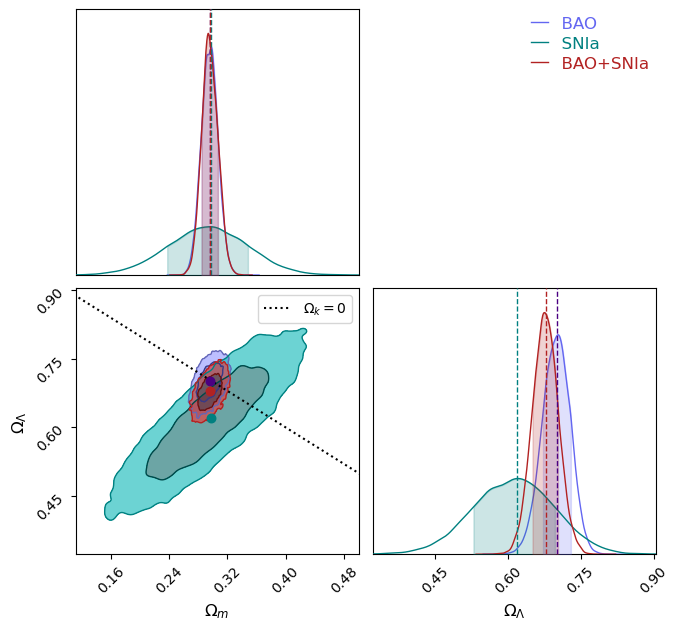

In [82]:
if do_all:

    c = ChainConsumer()
    if do_BAO: 
        c.add_chain(chain_bao)
        c.add_truth(truth_bao)
    if do_SN:
        c.add_chain(chain_snia)
        c.add_truth(truth_sn)
    c.add_chain(chain_all)
    c.add_truth(truth_all)


# Set desired limits for specific parameters
c.set_plot_config(
    PlotConfig(
        # shade=True,
        # legend=True,
        # figsize=(6, 6),
        parameters={
            r"$\Omega_\Lambda$": {"range": (0.4, 0.9)},
            r"$\Omega_m$": {"range": (0,0.5)},
        }
    )
)

#   fig=c.plotter.plot()
#   ax = fig.get_axes()[2]
#   ax.plot([0,1],[1,0],ls=':',color='k', label='$\Omega_\Lambda=0$')
#   plt.show()
#   fig.savefig("tot.png",dpi=300)

  # After creating the plot:
fig = c.plotter.plot()
ax = fig.get_axes()[2]
ax.plot([0, 1], [1, 0], ls=':', color='k', label=r'$\Omega_k=0$',zorder=10)
ax.legend()
# ax.set_ylim(0.4,.9)
# ax.set_xlim(0,.5)
fig.savefig("tot.png",dpi=300)

In [83]:
import chainconsumer
print (chainconsumer.__version__)

1.2.2
